# Import modules

In [3]:
from utils import * 

import numpy as np
import pandas as pd
from pprint import pprint
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Gensim
from gensim.test.utils import datapath
from gensim.test.utils import common_texts, get_tmpfile

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.option_context('display.max_colwidth', 500);

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


config = get_config('config.yaml')

In [4]:
# Import dataset
df = pd.read_csv(config['csv_input_local']['all_reviews_p3'], index_col=0)
df = df.reset_index(drop=True)
reviews = df.review
reviews

0        Your drivers are great BUT your support is no ...
1        Loving the app, but can only give it a medium ...
2        The response time with regards to customer ser...
3        This has been happening for some time now and ...
4        The drivers almost always never have change an...
                               ...                        
29808    It’s rather difficult to get a taxi. Sometimes...
29809    Taxi drivers don’t speak Estonian or English. ...
29810    Ride booking extension in Apple maps not avail...
29811    I ordered a taxi, but when it arrived the driv...
29812    taxis are always late without exception. drive...
Name: review, Length: 29813, dtype: object

In [5]:
# setup input and output path
input_path = 'preprocessed_data/_old2/all/'

term_doc = pd.read_pickle(input_path + 'term_doc.pkl')
data_lemmatized = pd.read_pickle(input_path + 'data_lemmatized.pkl')
dictionary = pd.read_pickle(input_path + 'dictionary.pkl')
tf_idf = pd.read_pickle(input_path + 'tf_idf.pkl')

In [6]:
len(data_lemmatized)

29813

# <mark>Mallet's LDA model after tuning &#8592; Best Model
*The difference between Mallet and Gensim’s standard LDA is that Gensim uses a Variational Bayes sampling method which is faster but less precise that Mallet’s Gibbs Sampling.*  [link](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)

In [7]:
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath("model"))
# ldamallet

In [8]:
%%time
# Solution on windows 10, fixing Java path on mallet.bat
# https://stackoverflow.com/questions/52845345/lda-mallet-calledprocesserror
# mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

# mallet_path = 'mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat'

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
#                                              corpus = term_doc,
#                                              num_topics = 6, 
#                                              random_seed = 100,
#                                              id2word = dictionary,
#                                              alpha = 1.5)

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=term_doc, num_topics=20, id2word=dictionary)

Wall time: 54.3 s


In [9]:
# ldamallet.save(datapath("model"))
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath("model"))

In [10]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('cab', 0.1447536788227767),
   ('fare', 0.08333333333333333),
   ('time', 0.0780550223928343),
   ('auto', 0.04782469609724888),
   ('booking', 0.04302623160588612),
   ('min', 0.0399872040946897),
   ('cancellation', 0.03358925143953935),
   ('hour', 0.032789507357645555),
   ('ola', 0.026871401151631478),
   ('night', 0.021753039027511197)]),
 (5,
  [('people', 0.14542160737812912),
   ('money', 0.13027009222661395),
   ('account', 0.07872200263504611),
   ('travel', 0.06768774703557312),
   ('amount', 0.0655467720685112),
   ('day', 0.05813570487483531),
   ('feedback', 0.018610013175230568),
   ('traveller', 0.016963109354413704),
   ('process', 0.015316205533596838),
   ('fact', 0.014492753623188406)]),
 (3,
  [('driver', 0.2830098631880369),
   ('minute', 0.1291759465478842),
   ('request', 0.06745147947820554),
   ('traffic', 0.03690741329939548),
   ('job', 0.03070314985682469),
   ('pickup', 0.027998727330575884),
   ('morning', 0.021317212853961185),
   ('street', 0

## Comparison of Coherence Score between LDA Standard and LDA Mallet

In [11]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=term_doc,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(term_doc))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.782363681463007

Coherence Score:  0.31258578114561864


## Visualize Mallet's LDA model

In [13]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, term_doc, dictionary)
vis

C:\Users\enlik\Miniconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.063291  0.118423       1        1  5.131686
8      0.089591  0.147654       2        1  5.076562
18     0.090674  0.097988       3        1  5.073464
3     -0.275112 -0.046889       4        1  5.039630
7      0.147427 -0.117299       5        1  5.031264
6      0.160304 -0.121706       6        1  5.030167
15     0.104126  0.208392       7        1  5.010248
16    -0.330150 -0.049276       8        1  5.009914
2     -0.226959 -0.010938       9        1  5.007182
5      0.086827  0.126638      10        1  5.006418
19     0.187620 -0.240883      11        1  5.000507
12    -0.261849 -0.056298      12        1  4.987423
1      0.205314 -0.278805      13        1  4.985986
10     0.094000 -0.243329      14        1  4.968576
13    -0.301552 -0.027976      15        1  4.964567
0      0.097073  0.192234      16        1  4.957918
17     0.084335  0.110932      17        1  4.947808
4      0.086617  0.154343      18        1  4.943353
9      0.098865  0.036658      19        1  4.917970
14    -0.200441  0.000138      20        1  4.909358, topic_info=                 Term          Freq         Total Category  logprob  loglift
5              driver  11140.000000  11140.000000  Default  30.0000  30.0000
14               ride   3806.000000   3806.000000  Default  29.0000  29.0000
35               time   4320.000000   4320.000000  Default  28.0000  28.0000
28                app   6114.000000   6114.000000  Default  27.0000  27.0000
45            service   3616.000000   3616.000000  Default  26.0000  26.0000
..                ...           ...           ...      ...      ...      ...
5              driver    853.169480  11140.270079  Topic20  -2.0009   0.4447
123        competitor     42.867584     84.154985  Topic20  -4.9918   2.3395
612   amazing_service     32.412076     53.116270  Topic20  -5.2713   2.5201
208           concept     25.093220     42.981881  Topic20  -5.5273   2.4758
697  great_experience     25.093220     87.435299  Topic20  -5.5273   1.7657

[1280 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
119      15  1.006139              ability
562      16  0.966211             able_get
1374     18  0.954263  absolutely_terrible
752      11  0.969496                abuja
1814      7  0.970872               accept
...     ...       ...                  ...
145      10  0.008992            yesterday
145      12  0.989166            yesterday
988      19  0.973110      yesterday_night
1185     15  0.951753                zahid
769      19  1.003520                 zone

[1703 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 9, 19, 4, 8, 7, 16, 17, 3, 6, 20, 13, 2, 11, 14, 1, 18, 5, 10, 15])

In [14]:
# pyLDAvis.save_html(vis, 'mallet_lda_vis/all/p3/mallet_lda_topics=20.html')
pyLDAvis.save_html(vis, 'mallet_lda_vis/all/p3/mallet_lda_topics=20_v2.html')

In [15]:
# coherence_model_m = CoherenceModel(model=model, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
# coherence_model_m.get_coherence_per_topic()

In [16]:
# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
model.top_topics(corpus = term_doc,topn=10)

[([(0.1447536788227767, 'cab'),
   (0.08333333333333333, 'fare'),
   (0.0780550223928343, 'time'),
   (0.04782469609724888, 'auto'),
   (0.04302623160588612, 'booking'),
   (0.0399872040946897, 'min'),
   (0.03358925143953935, 'cancellation'),
   (0.032789507357645555, 'hour'),
   (0.026871401151631478, 'ola'),
   (0.021753039027511197, 'night')],
  -3.819666560216312),
 ([(0.1397186660344555, 'customer'),
   (0.11379800853485064, 'charge'),
   (0.10715979137031768, 'company'),
   (0.04599336178283547, 'scam'),
   (0.03951319740793425, 'pay'),
   (0.029713924450766555, 'refund'),
   (0.028765607712976135, 'estimate'),
   (0.014856962225383278, 'care'),
   (0.013908645487592856, 'fault'),
   (0.013908645487592856, 'mistake')],
  -3.9851556140352944),
 ([(0.1201171875, 'issue'),
   (0.08821614583333333, 'problem'),
   (0.07259114583333333, 'app'),
   (0.06868489583333333, 'number'),
   (0.047688802083333336, 'address'),
   (0.03662109375, 'reason'),
   (0.027506510416666668, 'contact'),


### For each topic, we could look at frequent and relevant words

In [17]:
frequencies = ldamallet.word_topics.sum(axis=0)
p_word = frequencies / ldamallet.word_topics.sum()
p_word_given_topic = ldamallet.word_topics / np.sum(ldamallet.word_topics, axis = 0)

lamda = 0.5
relevance = lamda * p_word_given_topic + (1-lamda) * p_word_given_topic / p_word 

C:\Users\enlik\AppData\Local\Temp/ipykernel_9784/1698140663.py:3: RuntimeWarning: invalid value encountered in true_divide
  p_word_given_topic = ldamallet.word_topics / np.sum(ldamallet.word_topics, axis = 0)


In [18]:
np.argsort(relevance[0,])[::-1][:15]

array([5575, 1320, 6383, 4414, 6381,  356, 5060, 5787, 7243, 3051, 7690,
       3941, 4588, 1939,  168], dtype=int64)

In [19]:
dictionary[1826]

'saw'

In [20]:
topic_dict = {0.: "Platform/Device", 1.: "User Experience", 2.: "Value", 3.: "Service", 4.: "Trouble-shooting", 5.:"Shows"}

for topic_id in range(6):
    words = []
    for id in np.argsort(relevance[topic_id,])[::-1][:15]:
        words.append(dictionary[id])
    print(f"Topic: {topic_dict[topic_id]}")
    print(words)
    print('\n')

Topic: Platform/Device
['must', 'please', 'going to', 'thanx', 'would', 'help', 'nothing', 'known', 'on', 'aside', 'consider', 'indicate', 'around', 'th', 'none']


Topic: User Experience
['over', 'let', 'someone', 'going', 'off', 'an', 'everyone', 'value', 'welcome', 'brief', 'say', 'on', 'ever', 'furthermore', 'different']


Topic: Value
['contain', 'sub', 'cause', 'noone', 'please', 'wish', 'none', 'self', 'look', 'know', 'furthermore', 'trying', 'other', 'here', 'thanx']


Topic: Service
['using', 'everything', 'etc', 'willing', 'none', 'other', 'indicate', 'use', 'd', 'off', 'name', 'ok', 'around', 'can', 'everyone']


Topic: Trouble-shooting
['out', 'ask', 'etc', 'around', 'took', 'again', 'something', 'second', 'another', 'nobody', 'become', 'everything', 'saying', 'furthermore', 'different']


Topic: Shows
['sorry', 'thanx', 'nd', 'consider', 'sometime', 'contain', 'etc', 'up', 'wish', 'here', 'trying', 'right', 'third', 'willing', 'know']




## <mark>Mallet Model - Interpret the model</mark>

In [22]:
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath('model'))
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [23]:
df_topic_sents_keywords_m = format_topics_sentences(model, term_doc, data_lemmatized, df)

Getting main topic for document...
0  1000  2000  3000  4000  5000  6000  7000  8000  9000  10000  11000  12000  13000  14000  15000  16000  17000  18000  19000  20000  21000  22000  23000  24000  25000  26000  27000  28000  29000  

In [24]:
all_topics = model.get_document_topics(bow = term_doc)

In [25]:
# df_topic_sents_keywords_m[df_topic_sents_keywords_m[0]]
df_topic_sents_keywords_m

,Dominant_Topic,Perc_Contribution,Keywords,0
0,18.0,0.1060,"card, cash, application, support, response, em...","[driver, support, computer, response, case, re..."
1,14.0,0.0948,"love, driver, destination, journey, cost, vehi...","[rating, moment, driver, rating, trip, driver,..."
2,11.0,0.0937,"customer, charge, company, scam, pay, refund, ...","[response, reimbursement, part, customer, prom..."
3,5.0,0.0737,"people, money, account, travel, amount, day, f...","[time, show, estimate, amount, destination, lo..."
4,18.0,0.0833,"card, cash, application, support, response, em...","[driver, option, change, time, transfer, trust..."
...,...,...,...,...
29808,7.0,0.0917,"taxi, location, map, app, point, airport, feat...","[difficult_get, taxi, time, takes_lot, time, t..."
29809,5.0,0.0833,"people, money, account, travel, amount, day, f...","[money, card, money, taxi]"
29810,19.0,0.0735,"app, option, user, star, notification, screen,...","[ride, extension, apple, map, apple_pay]"
29811,14.0,0.0834,"love, driver, destination, journey, cost, vehi...","[driver, destination, destination, mad]"


In [26]:
# save to pickle file - df_topic_sents_keywords_m
import pickle

output_path = 'lda_mallet_model/'
# with open(output_path + 'mallet_lda_df_all_p3.pkl', 'wb') as f:
with open(output_path + 'mallet_lda_df_all_p3_v2.pkl', 'wb') as f:
    pickle.dump(df_topic_sents_keywords_m, f)


### Mallet LDA - Finding the dominant topic in each document

In [25]:
df_dominant_topic_m = find_dominant_topic_in_each_doc(df_topic_sents_keywords_m, df)
print("Finding the dominant topic in each document")
df_dominant_topic_m.head(10).style.set_properties(subset=['review'], **{'width': '400px'})

Finding the dominant topic in each document


,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
0,1.000000,0.087600,"card, payment, pay, app, support, cash, problem, detail, refund, week","['driver', 'support', 'computer', 'response', 'case', 'response', 'support', 'discount', 'account', 'thought', 'client']",3,"Your drivers are great BUT your support is no good. Why can't it be like Uber where you can actually speak to someone. Instead of getting computer generated responses or like in my case, no response at all. The three stars are for the support. Also I have received a single discount to this account since I installed it three months ago. I'm very disappointed in Bolt, I thought they were there for their clients."
1,13.000000,0.082200,"driver, work, app, show, rating, system, review, idea, business, competitor","['rating', 'moment', 'driver', 'rating', 'trip', 'driver', 'apartment', 'ride', 'drive', 'destination']",3,"Loving the app, but can only give it a medium rating at the moment as the drivers you give a bad rating on still gets your trip. I had a bad experience with a driver outside my apartment, but he always gets my rides as he's parked there when with my one star and bad review (refused to drive to the destination, rude and aggressive)."
2,6.000000,0.117400,"service, cab, discount, book, min, code, promotion, credit, promo, share","['response', 'reimbursement', 'part', 'customer', 'promo', 'part', 'situation', 'part', 'company', 'extra_money', 'people', 'card', 'dodgy', 'stick', 'amount', 'card']",4,The response time with regards to customer service was great and thank you. Kindly improve on the reimbursement part because it's not every customer who'll appreciate a promo. That part put some of us in a very sticky situation financially especially now that we have COVID-19. The last part would be for your company not to always take extra money just because people are paying with cards. That's dodgy. Stick to the same amount whether I'm paying cash or with a card.
3,13.000000,0.074900,"driver, work, app, show, rating, system, review, idea, business, competitor","['time', 'show', 'estimate', 'amount', 'destination', 'location', 'price', 'feedback', 'uninstall', 'rubbish', 'app']",1,This has been happening for some time now and i always keep quiet. You will show me an estimate of the amount for the destination and when i get to my location the price i will see will be way higher than what you showed. I will stop using you. Just decided to give this feedback before i uninstall this rubbish app
4,1.000000,0.105600,"card, payment, pay, app, support, cash, problem, detail, refund, week","['driver', 'option', 'change', 'time', 'transfer', 'trust', 'card', 'cash', 'please_fix', 'problem', 'way']",3,"The drivers almost always never have change and I'm left with no option but to leave my 100-300 naira change with them which I obviously don't intend to. It's not all the time we're able to transfer and not everyone trust using their cards with the app, for those of us that use cash please fix this problem whatever way, it's really annoying."
5,14.000000,0.068000,"driver, destination, passenger, map, application, change, screen, pickup, drop, transportation","['driver', 'driver', 'thing', 'customer', 'service', 'stopped_using']",1,I requested a ride and the driver (Akhona) completed the trip without picking me up. Money was deducted from my bank account and I have reported this 2 days ago and nothing has been resolved. The driver is driving around freely and probably doing the same thing to other customers. I've been using Bolt for more than 4 years now and must say I'm shocked at the customer support service. I've since stopped using bolt cause I'm afraid the same thing will happen again. Very very disappointed.
6,18.000000,0.081800,"driver, time, request, place, reason, cancellation, search, cancel, matter, choice","['month', 'unknown_error', 'message', 'time', 'driver', 'cancel', 'place', 'lift', 'fix', 'app', 'tomorrow']",3,Idk what is writing with this app.

In [26]:
df_dominant_topic_m

,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
0,1.0,0.0876,"card, payment, pay, app, support, cash, proble...","[driver, support, computer, response, case, re...",3,Your drivers are great BUT your support is no ...
1,13.0,0.0822,"driver, work, app, show, rating, system, revie...","[rating, moment, driver, rating, trip, driver,...",3,"Loving the app, but can only give it a medium ..."
2,6.0,0.1174,"service, cab, discount, book, min, code, promo...","[response, reimbursement, part, customer, prom...",4,The response time with regards to customer ser...
3,13.0,0.0749,"driver, work, app, show, rating, system, revie...","[time, show, estimate, amount, destination, lo...",1,This has been happening for some time now and ...
4,1.0,0.1056,"card, payment, pay, app, support, cash, proble...","[driver, option, change, time, transfer, trust...",3,The drivers almost always never have change an...
...,...,...,...,...,...,...
29808,8.0,0.1083,"price, taxi, drivers_alway, hailo, dollar, fri...","[difficult_get, taxi, time, takes_lot, time, t...",3,It’s rather difficult to get a taxi. Sometimes...
29809,2.0,0.0833,"money, phone, app, day, account, today, bill, ...","[money, card, money, taxi]",1,Taxi drivers don’t speak Estonian or English. ...
29810,11.0,0.0814,"app, rate, update, user, vehicle, message, per...","[ride, extension, apple, map, apple_pay]",3,Ride booking extension in Apple maps not avail...
29811,14.0,0.0871,"driver, destination, passenger, map, applicati...","[driver, destination, destination, mad]",1,"I ordered a taxi, but when it arrived the driv..."


### Get Average Ratings

In [27]:
# get list of unique values sorted - https://www.geeksforgeeks.org/python-get-unique-values-list/
list_unique_topics = np.unique(df_dominant_topic_m['Dominant_Topic'])

for topic in list_unique_topics:
    avg_rating = round(df_dominant_topic_m[df_dominant_topic_m['Dominant_Topic'] == topic]['rating'].mean(), 2)
    print('Average Rating for Topic ' + str(topic) + ' = ' + str(avg_rating))

Average Rating for Topic 0.0 = 4.23
Average Rating for Topic 1.0 = 2.31
Average Rating for Topic 2.0 = 2.62
Average Rating for Topic 3.0 = 3.58
Average Rating for Topic 4.0 = 2.84
Average Rating for Topic 5.0 = 3.33
Average Rating for Topic 6.0 = 3.37
Average Rating for Topic 7.0 = 4.36
Average Rating for Topic 8.0 = 3.22
Average Rating for Topic 9.0 = 2.49
Average Rating for Topic 10.0 = 3.96
Average Rating for Topic 11.0 = 3.33
Average Rating for Topic 12.0 = 3.52
Average Rating for Topic 13.0 = 3.19
Average Rating for Topic 14.0 = 3.12
Average Rating for Topic 15.0 = 2.11
Average Rating for Topic 16.0 = 3.47
Average Rating for Topic 17.0 = 2.87
Average Rating for Topic 18.0 = 2.81
Average Rating for Topic 19.0 = 3.4


### Get Average Sentiments

In [55]:
# # merge both apple and google
# df1 = pd.read_csv(config['csv_input_local']['bolt_apple_google_p1_topic_sentiment'], index_col=0)
# df1 = df1[['review','rating','sentiment_score']]

# df2 = pd.read_csv(config['csv_input_local']['uber_apple_google_p1_sentiment'], index_col=0)
# df2 = df2[['review','rating','sentiment_score']]

# df3 = pd.read_csv(config['csv_input_local']['blablacar_apple_google_p1_sentiment'], index_col=0)
# df3 = df3[['review','rating','sentiment_score']]

# df4 = pd.read_csv(config['csv_input_local']['cabify_apple_google_p1_sentiment'], index_col=0)
# df4 = df4[['review','rating','sentiment_score']]

# df5 = pd.read_csv(config['csv_input_local']['via_apple_google_p1_sentiment'], index_col=0) 
# df5 = df5[['review','rating','sentiment_score']]

# df6 = pd.read_csv(config['csv_input_local']['getaround_apple_google_p1_sentiment'], index_col=0)
# df6 = df6[['review','rating','sentiment_score']]

# df7 = pd.read_csv(config['csv_input_local']['olacabs_apple_google_p1_sentiment'], index_col=0)
# df7 = df7[['review','rating','sentiment_score']]

# df8 = pd.read_csv(config['csv_input_local']['taxieu_apple_google_p1_sentiment'], index_col=0)
# df8 = df8[['review','rating','sentiment_score']]

# df9 = pd.read_csv(config['csv_input_local']['freenow_apple_google_p1_sentiment'], index_col=0)
# df9 = df9[['review','rating','sentiment_score']]

# df10 = pd.read_csv(config['csv_input_local']['yandexgo_apple_google_p1_sentiment'], index_col=0)
# df10 = df10[['review','rating','sentiment_score']]

# df_merged = df1.append(df2, ignore_index=True)
# df_merged = df_merged.append(df3, ignore_index=True)
# df_merged = df_merged.append(df4, ignore_index=True)
# df_merged = df_merged.append(df5, ignore_index=True)
# df_merged = df_merged.append(df6, ignore_index=True)
# df_merged = df_merged.append(df7, ignore_index=True)
# df_merged = df_merged.append(df8, ignore_index=True)
# df_merged = df_merged.append(df9, ignore_index=True)
# df_merged = df_merged.append(df10, ignore_index=True)

# total_reviews = len(df_merged)

# print(f'Total merged reviews: {total_reviews} \n')
# df_merged

In [56]:
# df_merged.to_csv(config['csv_input_local']['all_reviews_p1_sentiment'])

In [57]:
df_sentiment = pd.read_csv(config['csv_input_local']['all_reviews_p1_sentiment'], index_col=0)
# df_sentiment = df_sentiment.head(20000) # testing purpose
df_sentiment

,review,rating,sentiment_score
0,The first thing I noticed is that you can't pr...,1,-1
1,Your GPS setting around Cape Town Internationa...,4,0
2,I was invited by my friend and was given a £10...,1,-1
3,Your drivers are great BUT your support is no ...,3,0
4,"Loving the app, but can only give it a medium ...",3,1
...,...,...,...
108082,A Yandex driver crashed into me ajulagedus I w...,1,0
108083,Geolocation is awful.,1,-3
108084,Localization? What localization?,1,0
108085,"That had promotion -50% with credit card, i or...",1,1


In [58]:
df_topic_p3 = df_dominant_topic_m[['Dominant_Topic','rating','review']]
# df_topic_p3 = df_topic_p3.head(40)
df_topic_p3

,Dominant_Topic,rating,review
0,1.0,3,Your drivers are great BUT your support is no ...
1,13.0,3,"Loving the app, but can only give it a medium ..."
2,6.0,4,The response time with regards to customer ser...
3,13.0,1,This has been happening for some time now and ...
4,1.0,3,The drivers almost always never have change an...
...,...,...,...
29808,8.0,3,It’s rather difficult to get a taxi. Sometimes...
29809,2.0,1,Taxi drivers don’t speak Estonian or English. ...
29810,11.0,3,Ride booking extension in Apple maps not avail...
29811,14.0,1,"I ordered a taxi, but when it arrived the driv..."


In [59]:
%%time
list_of_sentiment_scores_p3 = []

for i in range(0, len(df_topic_p3)):
    for j in range(0, len(df_sentiment)):
        if df_topic_p3['review'][i] == df_sentiment['review'][j]:
            sentiment_score = df_sentiment['sentiment_score'][j]
#             print(df_sentiment['review'][j])
#             print(df_sentiment['sentiment_score'][j])
#             print('\n')
            break
    
    if sentiment_score is None:
        sentiment_score = 0
        
    list_of_sentiment_scores_p3.append(sentiment_score)

Wall time: 7h 57min 40s


In [60]:
# list_of_sentiment_scores_p3

In [61]:
df_topic_p3['sentiment_score'] = list_of_sentiment_scores_p3
df_topic_p3

C:\Users\enlik\Miniconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Dominant_Topic,rating,review,sentiment_score
0,1.0,3,Your drivers are great BUT your support is no ...,0
1,13.0,3,"Loving the app, but can only give it a medium ...",1
2,6.0,4,The response time with regards to customer ser...,2
3,13.0,1,This has been happening for some time now and ...,-2
4,1.0,3,The drivers almost always never have change an...,0
...,...,...,...,...
29808,8.0,3,It’s rather difficult to get a taxi. Sometimes...,0
29809,2.0,1,Taxi drivers don’t speak Estonian or English. ...,-2
29810,11.0,3,Ride booking extension in Apple maps not avail...,0
29811,14.0,1,"I ordered a taxi, but when it arrived the driv...",-2


In [62]:
df_topic_p3.to_csv('../review_mining/csv_output/_all_reviews/all_reviews_p3_topic_sentiment.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../review_mining/csv_output/all/all_reviews_p3_topic_sentiment.csv'

In [ ]:
for topic in list_unique_topics:
    avg_sentiment = round(df_topic_p3[df_topic_p3['Dominant_Topic'] == topic]['sentiment_score'].mean(),2)
    print('Average Sentiment for Topic ' + str(topic) + ' = ' + str(avg_sentiment))

### Further Analysis

In [138]:
df_dominant_topic_m[df_dominant_topic_m['Dominant_Topic'] == 1.0]

,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
26,1.0,0.0786,"service, love, life, fast_efficient, download,...","[love, safety, measure, ability, friend]",5,I must say I love the safety measures and the ...
39,1.0,0.0660,"service, love, life, fast_efficient, download,...","[driver, app, love]",5,"The drivers are good, no wasting of time.This ..."
72,1.0,0.1001,"service, love, life, fast_efficient, download,...","[love, service, quality_driver, ride, suggesti...",5,Love the service and quality of drivers. My on...
89,1.0,0.0598,"service, love, life, fast_efficient, download,...","[driver, service]",4,The drivers are very relatable and friendly. T...
153,1.0,0.0791,"service, love, life, fast_efficient, download,...","[good_price, service, love]",5,Good prices. Easy to use. Drivers are friendly...
...,...,...,...,...,...,...
10723,1.0,0.0609,"service, love, life, fast_efficient, download,...",[service],5,Perfect services
10729,1.0,0.0659,"service, love, life, fast_efficient, download,...","[design, navigation, app, love]",5,This app is great. Design is simple and clear....
10748,1.0,0.0598,"service, love, life, fast_efficient, download,...","[app, service]",5,Will use this app here in Tbilisi and this is ...
10751,1.0,0.0686,"service, love, life, fast_efficient, download,...",[love],5,Just so simple quick cheap and easy- love it!


### Mallet LDA - Find the most representative document for each topic

In [48]:
print("Find the most representative document for each topic")
sent_topics_sorteddf_m = find_most_representative_doc_for_each_doc(df_topic_sents_keywords_m, df)
sent_topics_sorteddf_m.style.set_properties(subset=['review'], **{'width': '400px'})

Find the most representative document for each topic


,Dominant_Topic,Perc_Contribution,Topic_Keywords,star_rating,review
0,0.000000,0.132800,"price, destination, experience, friendly_driver, change, easy_use, competitor, good_price, comfort, increase",3,"Really good app, trustworthy, but the only problem I'm facing for the last 2 weeks is their price that's automatically just increase due to high demand, you would think when the demand is high, it would be cheaper but it increases in minutes, even in 1 minute, you check now, 1min later its like double the price. I normally pay R37 to take my son to school which is 3.5km,when the ""demand is high"" it goes up to R91, that's just way too ridiculous. And that's when customers choose another app."
1,1.000000,0.112000,"service, love, life, fast_efficient, download, rude, affordable_price, mind, availability, really_good",5,"the best app to get from A to B. This statement might seem simple, but the guys who drive for taxify are amazing. their friendliness, kindness, and willingness make me wanna use it every single day! love it love it love it"
2,2.000000,0.175900,"time, taxi, drivers_alway, point, pricing, pickup, travel, driving, drop, order",3,"The prices vary multiple euros (more expensive) if the taxi is using a taximeter or using the app for the fare pricing. The app calculates a higher fare charge if you take same taxi fare pricing, but with different means of measurments. The trip from work to home costs around 7-8 euros with a taximeter taxi, but the private or the a taxi what uses the app, its 10-11 euros, even though the pricing is sometimes even cheaper than the taximeter taxi."
3,3.000000,0.168300,"location, map, app, address, area, order, pick, feature, improvement, street",3,"Can't set default home address. Can't add favourites. Why? These should be the rock bottom minimum! Trying to use current location always sets wrong address. Address picked on the map never gets stored. Not useless, but that's all. It is very far from an app that can be considered good. EDIT: My bad - thank you, i can set Home now. I still can't set frequent addresses (besides work) and still can't check my address history to reuse an address. But at least, with home address set, it's feels a bit more OK now."
4,4.000000,0.116400,"driver, app, phone, lot, man, move, booking, cancel_trip, drive, instance",3,"I wish the bolt Kenya team would train some of their drivers on proper customer care techniques. For instance I'd request a taxi or a boda and the driver just calls and asks , where are you. No no no, nobody wants a new number calling her/him and asking where are you. Let it be a bit courteous, like hello X, I'm your driver from taxify bla bla bla. That would help."
5,5.000000,0.131900,"driver, experience, client, end, rating, cancel, condition, music, professional, conversation",1,I had to come back here after years of using your app to edit my review. Your platform have been so filled with messed up drivers these days to the extent of having 2 drivers cancel my order and stated client didn't show up when I had to actually wait endlessly for them till they cancelled the trip from there end. On most cases your driver don't show up and when client cancel to search a new ride the client get automatically blocked after 3 attempts. This is so awful. WORK ON UR DRIVERS PLS!!!
6,6.000000,0.148900,"work, issue, thing, traffic, friend, drive, scam, user, transport, yesterday",3,App's basics are ok but I've got 2 issues with it: The driver tracking tech/mapping solution aren't that good as it sometimes struggles to find addresses and at other times doesn't even track their driver. The driver timing tracking is also a disappointment as they give you an estimated time but are always late. I understand that traffic jams and other things might lead to lateness but I'm talking of lateness because you can see that the driver is not moving at all as per the app's tracking.
7,7.000000,0.153800,"driver, passenger, vehicle, case, city, scooter, transportation, arr

### Mallet LDA - Topic distribution across documents

In [49]:



# Show
print("Topic distribution across documents")
df_dominant_topic_m = topic_distribution_across_docs(df_topic_sents_keywords_m)
df_dominant_topic_m.style.set_properties(subset=['Keywords'], **{'width': '400px'})

Topic distribution across documents


,Dominant_Topic,Keywords,Num_Documents,Perc_Documents
0,0.000000,"price, destination, experience, friendly_driver, change, easy_use, competitor, good_price, comfort, increase",2234,0.207100
1,1.000000,"service, love, life, fast_efficient, download, rude, affordable_price, mind, availability, really_good",764,0.070800
2,2.000000,"time, taxi, drivers_alway, point, pricing, pickup, travel, driving, drop, order",762,0.070700
3,3.000000,"location, map, app, address, area, order, pick, feature, improvement, street",628,0.058200
4,4.000000,"driver, app, phone, lot, man, move, booking, cancel_trip, drive, instance",577,0.053500
5,5.000000,"driver, experience, client, end, rating, cancel, condition, music, professional, conversation",509,0.047200
6,6.000000,"work, issue, thing, traffic, friend, drive, scam, user, transport, yesterday",503,0.046600
7,7.000000,"driver, passenger, vehicle, case, city, scooter, transportation, arrival, item, promotion",492,0.045600
8,8.000000,"service, charge, email, cab, month, hour, reply, good, year, person",482,0.044700
9,9.000000,"card, money, problem, pay, account, application, detail, error, card_payment, report",450,0.041700


In [50]:
coherence_model = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
coherence_model.get_coherence_per_topic()

[-0.3859722375980065,
 -0.4400739444899253,
 -0.39269635901126976,
 -0.19087517450090455,
 -0.3398570277009598,
 -0.37344484381287124,
 -0.2706560845588571,
 -0.4073855899215104,
 -0.31194768484711605,
 -0.13962156983785015,
 -0.19175268009333887,
 -0.3078099602216355,
 -0.3611080409611231,
 -0.4019334546193137,
 -0.36697212981419114,
 -0.16224009256804012,
 -0.22337262487599685,
 -0.2527600132588836,
 -0.28825299940060045,
 -0.3504262293895318]

# Find Optimal Number of Topics

In [64]:
# Solution on windows 10, fixing Java path on mallet.bat
# https://stackoverflow.com/questions/52845345/lda-mallet-calledprocesserror
# mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

# mallet_path = 'mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat'

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=term_doc, num_topics=5, id2word=dictionary)

Wall time: 0 ns


In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [66]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=term_doc, texts=data_lemmatized, start=2, limit=40, step=6)


Wall time: 6min 57s


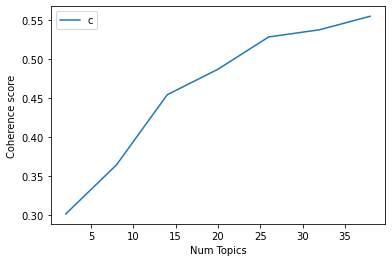

In [67]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.301
Num Topics = 8  has Coherence Value of 0.364
Num Topics = 14  has Coherence Value of 0.4539
Num Topics = 20  has Coherence Value of 0.4867
Num Topics = 26  has Coherence Value of 0.5281
Num Topics = 32  has Coherence Value of 0.5372
Num Topics = 38  has Coherence Value of 0.5546


In [69]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.124*"issue" + 0.097*"problem" + 0.073*"response" + 0.057*"company" + '
  '0.051*"complaint" + 0.042*"refund" + 0.039*"month" + 0.036*"week" + '
  '0.024*"safety" + 0.022*"team"'),
 (1,
  '0.533*"time" + 0.102*"taxi" + 0.076*"drivers_alway" + 0.028*"arrival" + '
  '0.019*"pickup" + 0.016*"everytime" + 0.015*"estimation" + 0.012*"part" + '
  '0.006*"page" + 0.005*"simple_use"'),
 (2,
  '0.187*"location" + 0.149*"minute" + 0.098*"map" + 0.056*"order" + '
  '0.040*"show" + 0.039*"pick" + 0.037*"direction" + 0.027*"pick_location" + '
  '0.019*"city" + 0.019*"move"'),
 (3,
  '0.435*"driver" + 0.080*"route" + 0.062*"passenger" + 0.048*"client" + '
  '0.044*"vehicle" + 0.029*"case" + 0.017*"situation" + 0.013*"deal" + '
  '0.009*"tip" + 0.009*"function"'),
 (4,
  '0.166*"app" + 0.157*"work" + 0.072*"driver" + 0.062*"drive" + '
  '0.061*"address" + 0.032*"transportation" + 0.024*"home" + 0.021*"year" + '
  '0.016*"kind" + 0.015*"platform"'),
 (5,
  '0.204*"app" + 0.153*"driver" + 0.10